In [1]:
import MySQLdb
import random
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
db = MySQLdb.connect(  # esto hace la conexion a la base de datos
    host="localhost",  # el puerto es 3308 porque es el puerto que
    user="root",  # le deje a mariaDB
    password="deadzamxd",
    database="PokeSearch",
    port=3308,
)
c = db.cursor()

In [3]:
TYPES = dict()
c.execute(f"select * from tipe;")
result = c.fetchall()
for tipe in result:
    TYPES[tipe[0]] = tipe[1]
relations = dict()
for t_id in TYPES:
    if t_id not in relations:
        relations[t_id] = dict()
    c.execute(
        f"select relation,id_type_2 from relation_type where id_type_1={t_id} and relation like '%from' ;"
    )
    temp = c.fetchall()
    for rt in temp:
        if rt[0] not in relations[t_id]:
            relations[t_id][rt[0]] = []
            relations[t_id][rt[0]].append(rt[1])
        else:
            relations[t_id][rt[0]].append(rt[1])


In [4]:
def damages(T: list):
    D = dict()
    for t in T:
        for rt in relations[t]:
            for ti in relations[t][rt]:
                if ti in D:
                    if rt == "double_damage_from":
                        D[ti] *= 2
                    elif rt == "half_damage_from":
                        D[ti] *= 0.5
                    else:
                        D[ti] *= 0
                else:
                    if rt == "double_damage_from":
                        D[ti] = 2
                    elif rt == "half_damage_from":
                        D[ti] = 0.5
                    else:
                        D[ti] = 0
    return D



In [5]:
class Pokemon:
    def __init__(self, name: str):
        c.execute(
            f"select id,atk,satk,def,sdef,total_stat,name,hp,spe from pokemon where name='{name}';"
        )
        data = c.fetchone()
        self.id = data[0]
        self.atk = data[1]
        self.defe = data[3]
        self.satk = data[2]
        self.sdef = data[4]
        self.total = data[5]
        self.name = data[6]
        self.hp = data[7]
        self.spe = data[8]
        c.execute(f"select id_type from pok_typ where id_pokemon={data[0]};")
        T = c.fetchall()
        self.types = []
        for t in T:
            self.types.append(t[0])
        self.damages = damages(self.types)

        self.moves = {"physical": dict(), "status": dict(), "special": dict()}
        self.all = []
        c.execute(
            f"select M.name,M.id_type,M.damage_class from move as M inner join pok_mov as PM on  PM.id_move=M.id and PM.id_pokemon={self.id};"
        )
        M = c.fetchall()
        for att in M:
            if att[1] not in self.moves[att[2]]:
                self.moves[att[2]][att[1]] = list()
            self.moves[att[2]][att[1]].append(att[0])
            self.all.append(att[0])

    def print(self):
        print(f"""id = {self.id}\natk = {self.atk}\ndefe = {self.defe}\nsatk = {self.satk}\nsdef = {self.sdef}\ntotal = {self.total}\nname = {self.name}""")
        for d in self.damages:
            print(TYPES[d],":",self.damages[d])
        for M in self.moves:
            print(M)
            for m in self.moves[M]:
                print(f"{TYPES[m]}:{self.moves[M][m]}")


In [6]:
class PokemonT:
    def __init__(self,poke: Pokemon,moves =[],mode="normal",EV=[85,85,85,85,85,85],IV=[31,31,31,31,31,31]):
        if sum(EV)>510 or False in [ev<253 for ev in EV]:
            print("EV mal distribuidos... Distribuyendolos")
            EV=[85,85,85,85,85,85]

        self.hp = math.floor(110+((2*poke.hp)+IV[0]+(EV[0]/4)))
        self.eva = 3
        self.pre = 3
        self.atk = math.floor((2*poke.atk)+IV[1]+(EV[1]/4)+5)
        self.defe = math.floor((2*poke.defe)+IV[2]+(EV[2]/4)+5)
        self.satk = math.floor((2*poke.satk)+IV[3]+(EV[3]/4)+5)
        self.sdef = math.floor((2*poke.sdef)+IV[4]+(EV[4]/4)+5)
        self.spe = math.floor((2*poke.spe)+IV[5]+(EV[5]/4)+5)
        self.name = poke.name
        self.types = [TYPES[t] for t in poke.types]
        self.damages = {TYPES[k]:v for (k,v) in poke.damages.items() } 

        for i in range(len(moves)):
            if moves[i] not in poke.all:
                moves[i] = random.choice(poke.all)
        moves.extend([random.choice(poke.all) for _ in range(4-len(moves))])

        if mode=="test":
            moves = []
            moves.extend([f"a{c}_{poke.types[0]:02}" for c in ["s","p"]])
            moves.extend([f"a{c}_19" for c in ["s","p"]])

        self.moves = [moveT(m) for m in moves]
        

In [7]:
#c.execute(f'select * from pokemon where name="charizard";')
#data = c.fetchall()
#data

In [8]:
class moveT:
    def __init__(self,name:str):
        c.execute(
            f"select * from move where name='{name}';"
        )
        data = c.fetchone()
        self.id = data[0]
        self.name = data[1]
        self.type = TYPES[data[2]]
        self.clss = data[3]
        self.power = data[4]
        self.pp = data[5]
        self.acc = data[6]
        self.prio = data[7]
        self.ail = data[8]
        self.ail_c = data[9]
        self.eff = data[10]

    def print(self):
        print(f"id = {self.id}\nname = {self.name}\ntype = {self.type}\nclss = {self.clss}\npower = {self.power}\npp = {self.pp}\nacc = {self.acc}\nprio = {self.prio}\nail = {self.ail}\nail_c = {self.ail_c}\neffect = {self.eff}")

In [9]:
#m = moveT("as_10")
#m.print()

dummy = Pokemon("dummy")
Dummy = PokemonT(poke=dummy)
Dummy.hp

672

In [10]:
#p1 = Pokemon("pikachu")
#print(len(p1.all))
#p2 = Pokemon("geodude")
#p2.print()


#p1 = Pokemon("charizard")
#P1 = PokemonT(poke=p1,mode="test",EV=[6,252,0,252,0,0])
#print(f"atk: {P1.atk}\nsatk: {P1.satk}")

In [11]:
test = PokemonT(Pokemon("victini"),mode="test")
for m in test.moves:
    print(m.name)

as_10
ap_10
as_19
ap_19


In [12]:
def attack(user:PokemonT,move:moveT, target:PokemonT,mode='normal'):
    if move.clss == "special": 
        Ataque = user.satk
        Defensa = target.sdef
    elif move.clss == "physical":
        Ataque = user.atk
        Defensa = target.defe
    if move.type in user.types: STAB = 1.5
    else: STAB = 1
    if move.type in target.damages:
        effect = target.damages[move.type]
    else:
        effect = 1
    rnd = 100
    #if mode=='test': rnd=100
    #else: rnd = (random.randint(217,255)*100)/255
    #damage = ((((((100 * 2 / 5) + 2) * move.power * Ataque / 50) / Defensa) * 1 + 2) * 1 * 1 * rnd / 100) * STAB * effect
    damage = math.floor(((((((100 * 2 / 5) + 2) * move.power * Ataque / 50) / Defensa) + 2)* 1 * rnd / 100) * STAB * effect)
    #print(damage)
    target.hp -= damage
    return target,damage
    #acc = (move.acc/100)*((user.pre/3)/(target.eva/3))
    #print(acc)

In [16]:
def parametrizarATK(pokemon:Pokemon,Dummy:PokemonT):
    EVs = [[0,0,0,0,0,0],[0,85,0,85,0,0],[0,252,0,252,0,0]]
    X = []
    Y = []
    L = []
    rest = Dummy.hp
    for evs in EVs:
        P1 = PokemonT(poke=pokemon,mode="test",EV=evs)
        X.append(f"atk: {P1.atk}\n(EV={evs[1]})\n{P1.moves[1].name}")
        c = 0
        while Dummy.hp>0:
            Dummy,damage = attack(P1,P1.moves[1],Dummy)
            c+=1
        Y.append(c)
        Dummy.hp = rest
        L.append("dpa: "+str(damage))

        X.append(f"satk: {P1.satk}\n(EV={evs[3]})\n{P1.moves[0].name}")
        c = 0
        while Dummy.hp>0:
            Dummy,damage = attack(P1,P1.moves[0],Dummy)
            c+=1
        Y.append(c)
        Dummy.hp = rest
        L.append("dpa: "+str(damage))

        P1 = PokemonT(poke=pokemon,mode="test",EV=evs)
        X.append(f"atk: {P1.atk}\n(EV={evs[3]})\n{P1.moves[3].name}")
        c = 0
        while Dummy.hp>0:
            Dummy,damage = attack(P1,P1.moves[3],Dummy)
            c+=1
        Y.append(c)
        Dummy.hp = rest
        L.append("dpa: "+str(damage))

        X.append(f"satk: {P1.satk}\n(EV={evs[3]})\n{P1.moves[2].name}")
        c = 0
        while Dummy.hp>0:
            Dummy,damage = attack(P1,P1.moves[2],Dummy)
            c+=1
        Y.append(c)
        Dummy.hp = rest
        L.append("dpa: "+str(damage))

    plt.figure(figsize=(12, 6))

    colors = cm.get_cmap('Pastel1', len(X))

    bars = plt.bar(X,Y,color=[colors(i) for i in range(len(X))])
    for bar, leyenda in zip(bars, L):
        bar.set_label(leyenda)
        yval = bar.get_height()  # Obtiene la altura de la barra (el valor en Y)
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval}', ha='center', va='bottom')

    plt.title(f'{pokemon.name} vs {Dummy.name}')
    plt.xlabel('Parametros')
    plt.ylabel('Ataques necesitados')
    plt.legend()
    plt.show()

C:\Users\EQUIPO\AppData\Local\Temp\ipykernel_15196\2415723404.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Pastel1', len(X))


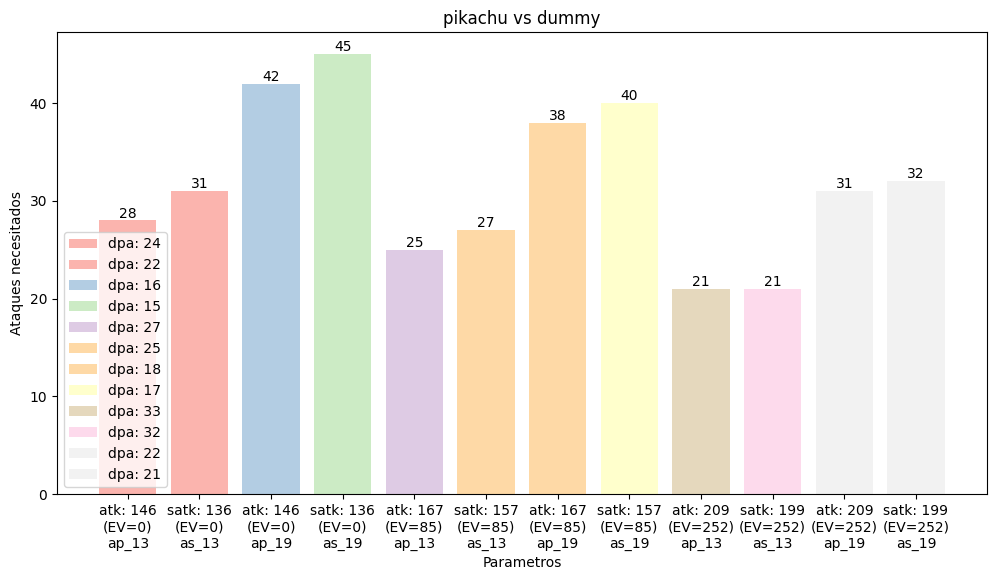

In [17]:
p1 = Pokemon("pikachu")
parametrizarATK(p1,Dummy=Dummy)

In [15]:
""" sp = [f'insert into move values(191{i+1:02},"as_{i+1:02}",{i+1},"special",60,15,100,0,NULL,NULL,"test above {TYPES[i+1]} attack special");' for i in range(19)]
sp.extend([f'insert into move values(190{i+1:02},"ap_{i+1:02}",{i+1},"physical",60,15,100,0,NULL,NULL,"test above {TYPES[i+1]} attack special");' for i in range(19)])
for q in sp:
    print(q) """

' sp = [f\'insert into move values(191{i+1:02},"as_{i+1:02}",{i+1},"special",60,15,100,0,NULL,NULL,"test above {TYPES[i+1]} attack special");\' for i in range(19)]\nsp.extend([f\'insert into move values(190{i+1:02},"ap_{i+1:02}",{i+1},"physical",60,15,100,0,NULL,NULL,"test above {TYPES[i+1]} attack special");\' for i in range(19)])\nfor q in sp:\n    print(q) '

Daño (PS) = [{([{(Nv. * 2 / 5) + 2} * Poder * Ataque / 50] / Defensa) * 1 + 2} * CH * 1 * Rnd / 100] * STAB * Efec.Tipo#1 * Efec.Tipo#2 * 1

Donde:

Nv.=El Nivel del Pokémon usuario.
Poder=Poder del Movimiento que el Pokémon usuario utiliza.
Ataque=Ataque o Ataque Especial del Pokémon usuario; depende de la Categoría del Movimiento: Si es Físico se utiliza el Ataque, si es Especial se utiliza el Ataque Especial.
Defensa=Defensa o Defensa Especial del Pokémon rival; depende de la Categoría del Movimiento: Si es Físico se utiliza la Defensa, si es Especial se utiliza la Defensa Especial.
CH (Critical Hit) =Modificador de la fórmula equivalente a.....
» 2 si el Movimiento es Golpe Crítico.
» 1 para cualquier otro caso.
Rnd (Random)=Número entero de valor aleatorio que va desde 85 hasta 100. Rnd = (R * 100 / 255). Donde R es un número entero de valor aleatorio que va desde 217 hasta 255 con uniforme probabilidad de aparición.
STAB (Same Type Attack Bonus)=Modificador de la fórmula equivalente a.....
» 1.5 si el Tipo del Movimiento coincide con alguno de los Tipos del Pokémon usuario.
» 1 para cualquier otro caso.
Efec.Tipo#1 = Modificador de la fórmula equivalente a.....
» 2 si el Movimiento es muy efectivo con respecto al 1° Tipo del Pokémon rival.
» 0.5 si el Movimiento no es muy efectivo con respecto al 1° Tipo del Pokémon rival.
» 0 si el Movimiento no afecta al 1° Tipo del Pokémon rival.
» 1 para cualquier otro caso.
Efec.Tipo#2=Modificador de la fórmula equivalente a.....
» 2 si el Movimiento es muy efectivo con respecto al 2° Tipo del Pokémon rival.
» 0.5 si el Movimiento no es muy efectivo con respecto al 2° Tipo del Pokémon rival
» 0 si el Movimiento no afecta al 2° Tipo del Pokémon rival.
» 1 si el rival solo tiene un Tipo o para cualquier otro caso.